# Qcodes example with DelegateInstrument driver

This notebooks explains how to use the `DelegateInstrument` driver.

## About
The goal of the `DelegateInstrument` driver is to make it easier to combine different parameters together into a new "virtual" instrument. Each parameter on a `DelegateInstrument` can point to one or more parameters on other instruments in the station.

## Usage
The way it's used is mainly by specifying an entry in the station YAML. For instance, let's say you want to use a magnetic field coil. The driver has a method set_field(value, block), that by default is set to block=True, which means the field is ramped in a way that blocks further execution until the desired value is reached. However, let's say you are creating a measurement in which you want the parameter to be set, and while the value is ramping, you want to measure other parameters. This can be done by using `DelegateInstrument` and specifying a custom `setter` for the parameter that gets and sets the magnetic field.

By default, each parameter is represented by a `DelegateParameter`. The `DelegateInstrument` also supports passing multiple source parameters to a given parameter. In order to do this, simply specify multiple parameters in the dictionary values  under the `parameters` key.

It can also add instrument channels, specified under a separate key `channels`, shown in the second half of the notebook.

In [1]:
%%writefile delegate_instrument_example.yaml

instruments:
  field_X:
    type: qcodes.instrument_drivers.mock_instruments.MockField

  field:
    type: qcodes.instrument.delegate.DelegateInstrument
    init:
      parameters:
        X:
          - field_X.field
        ramp_rate:
          - field_X.ramp_rate
        combined:
          - field_X.field
          - field_X.ramp_rate
      set_initial_values_on_load: true
      initial_values:
        ramp_rate: 1.0
      setters:
        X:
          method: field_X.set_field
          block: false

Writing delegate_instrument_example.yaml


In [2]:
from pathlib import Path

import qcodes as qc
from qcodes.dataset import (
    Measurement,
    initialise_or_create_database_at,
    load_or_create_experiment,
)

In [3]:
station = qc.Station(config_file="delegate_instrument_example.yaml")

In [4]:
field_X = station.load_field_X()
field = station.load_field(station=station)

In [5]:
field.X()

0.0

In [6]:
field.X(1.0)

In [7]:
field.X()

7.177988688151042e-05

In [8]:
field.X()

0.00016117095947265625

In [9]:
field.X()

0.00023996829986572266

In [10]:
field.X()

0.0003225445747375488

As you can see, the field is now ramped in the background with the specified ramp rate. Now, let's try to create a measurement that uses this ability, and ramps the field in the background while measuring:

In [11]:
field.ramp_rate(10.0)
field_X.field(0.0)

In [12]:
field.X()

0.0

In [13]:
import time

initialise_or_create_database_at(
    Path.cwd().parent / "example_output" / "delegate_instrument_example.db"
)
load_or_create_experiment("delegate_instrument_experiment")

meas = Measurement(station=station)
meas.register_parameter(field.X)

with meas.run() as datasaver:
    for B in [0.1, 0.0]:
        field.X(B)
        while field.X() != B:
            datasaver.add_result((field.X, field.X()))
            time.sleep(0.01)
    datasaver.flush_data_to_database()

Starting experimental run with id: 1. 


<Axes: >

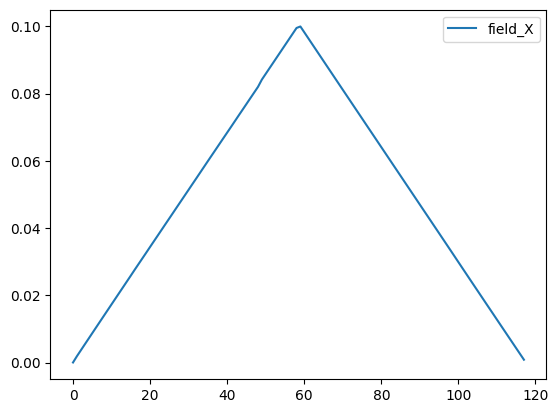

In [14]:
datasaver.dataset.to_pandas_dataframe().plot()

When specifying multiple source parameters on a given parameter, the grouped parameter will automatically return a `namedtuple` that returns both values.

In [15]:
field.combined()

combined(field=0.0, ramp_rate=10.0)

We can now also create a custom parameter that does a simple calculation based on the current parameters.

In [16]:
import numpy as np


def calculate_ramp_time(X, ramp_rate):
    """Calculate ramp time in seconds"""
    dfield = np.abs(field.target_field - X)
    return 60.0 * dfield / ramp_rate

In [17]:
field._create_and_add_parameter(
    group_name="ramp_time",
    station=station,
    paths=["field_X.field", "field_X.ramp_rate"],
    formatter=calculate_ramp_time,
)

In [18]:
field.ramp_rate(1.0)
field.target_field = 0.1
field.ramp_time()

np.float64(6.0)

In [19]:
field.X(0.1)

In [20]:
field.ramp_time()

np.float64(5.995663642883301)

In [21]:
import time

time.sleep(1.0)
field.ramp_time()

np.float64(4.990005970001221)

In [22]:
import time

time.sleep(1.0)
field.ramp_time()

np.float64(3.98350191116333)

## Devices with channels

The YAML file below specifies the instruments with the channels/parameters we wish to group into a new instrument, here called "device". The first example simply adds the channel 'as is' using self.add_submodule, while the readout parameter is added as a DelegateParameter.

In [23]:
%%writefile delegate_instrument_example.yaml

instruments:
  lockin:
    type: qcodes.instrument_drivers.mock_instruments.MockLockin

  dac:
    type: qcodes.instrument_drivers.mock_instruments.MockDAC

  device:
    type: qcodes.instrument.delegate.DelegateInstrument
    init:
      parameters:
        readout: lockin.X
      channels:
        gate_1: dac.ch01
      set_initial_values_on_load: true
      initial_values:
        readout: 1e-5
        gate_1.voltage.post_delay: 0.01

Overwriting delegate_instrument_example.yaml


In [24]:
station = qc.Station(config_file="delegate_instrument_example.yaml")

In [25]:
lockin = station.load_lockin()
dac = station.load_dac()
device = station.load_device(station=station)

In [26]:
print(device.gate_1)
print(device.gate_1.voltage.post_delay)

<MockDACChannel: dac_ch01 of MockDAC: dac>
0.01


In [27]:
print(device.gate_1.voltage())
device.gate_1.voltage(-0.6)
device.gate_1.voltage()

0.0


-0.6

The second example adds a channel using a custom channel class, which takes the initial channel and its name as input and has a parameter current_valid_ranges.

In [28]:
%%writefile delegate_instrument_example.yaml

instruments:
  lockin:
    type: qcodes.instrument_drivers.mock_instruments.MockLockin

  dac:
    type: qcodes.instrument_drivers.mock_instruments.MockDAC

  device:
    type: qcodes.instrument.delegate.DelegateInstrument
    init:
      parameters:
        readout: lockin.X
      channels:
        type: qcodes.instrument_drivers.mock_instruments.MockCustomChannel
        gate_1:
          channel: dac.ch01
          current_valid_range: [-0.5, 0]
      set_initial_values_on_load: true
      initial_values:
        readout: 1e-5

Overwriting delegate_instrument_example.yaml


In [29]:
lockin.close()
dac.close()

In [30]:
station = qc.Station(config_file="delegate_instrument_example.yaml")
lockin = station.load_lockin()
dac = station.load_dac()

In [31]:
device = station.load_device(station=station)

In [32]:
device.gate_1

<MockCustomChannel: dac_gate_1 of MockDAC: dac>

In [33]:
device.gate_1.voltage(-0.3)

In [34]:
device.gate_1.voltage()

-0.3

The MockCustomChannel has a parameter `current_valid_range`.

In [35]:
device.gate_1.current_valid_range()

[-0.5, 0]